### (PSL) Project 1

#### Member
| Field         | Value                |
|---------------|----------------------|
| Name          | Lee Yu Chung, Paul   |
| UID           | 665451160            |
| NetID         | ycl7                 |
| Program       | MCS-DS               |
| Contributions | 100%                 |



### Dataset Origin
The training and test splits are derived from the Ames Housing data. For more background on this dataset, you can refer to:

- De Cock, D. (2011). “Ames, Iowa: Alternative to the Boston Housing Data as an End of Semester Regression Project,” Journal of Statistics Education, Volume 19, Number 3. [PDF]

- Check variable description [Here]

- This dataset also features in a Kaggle competition (https://www.kaggle.com/c/house-prices-advanced-regression-techniques). Our dataset, however, has two additional explanatory variables: “Longitude” and “Latitude”. Exploring the Kaggle competition can offer insights on data analysis approaches and sample codes.

### Project Objective
Your task is to predict the price of homes, but importantly, in log scale. You need to build TWO prediction models selected from the following two categories:

- one based on linear regression models with Lasso or Ridge or Elasticnet penalty;
- one based on tree models, such as randomForest or boosting tree.

**Note:**
- The features selected for the two models can differ.
- PID cannot be used as a feature. PID is a unique identifier for parcels of land or properties assigned by the county. It’s more like an index and has no logical connection to housing price determinants.
- Please refer to Campuswire to identify the packages that are permissible for use in this project.


In [1]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint
from scipy.stats import skew, pearsonr
import warnings
warnings.filterwarnings('ignore')

# set random seed
seed_val = 1160
np.random.seed(seed_val)

#### Data preprocessing
- Load: Loading the data from CSV files
- Clean: data cleansing to remove errors or inconsistencies
- Impute: Impute any missing values
- Encode: Encoding the statistical data type (numeric, categorical)

#### Load

In [2]:
# Targeted directory
target_fold_dir = 'fold2'
# import the fold1 data
X_train_full = pd.read_csv(f'{target_fold_dir}/train.csv', index_col='PID')
X_train = X_train_full.iloc[:, 1:-1] # exclude the first column and the last two columns
y_train = np.log(X_train_full.iloc[:, -1])

# import the test data
X_test_full = pd.read_csv(f'{target_fold_dir}/test.csv', index_col='PID')
test_data_y = pd.read_csv(f'{target_fold_dir}/test_y.csv', index_col='PID')

X_test = X_test_full.iloc[:, 1:] # exclude the first column and the last two columns
y_test = np.log(test_data_y.iloc[:, -1])

In [3]:
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

y_train_processed = y_train.copy()
y_test_processed = y_test.copy()

Drop 16 rows


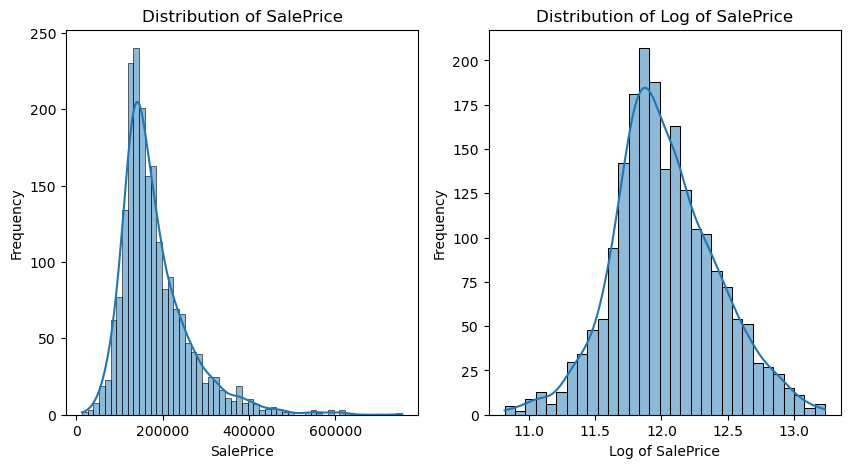

In [4]:
# plot the sales price distribution (original, log)
y_train_original = X_train_full.iloc[:, -1]

# drop the rows with extreme price larger
mean = y_train.mean()
std = y_train.std()    
rows_to_drop = y_train[(y_train > mean + 3 * std) | (y_train < mean - 3 * std)].index
print(f'Drop {len(rows_to_drop)} rows')
X_train_processed = X_train_processed.drop(index=rows_to_drop)
y_train_processed = y_train_processed.drop(index=rows_to_drop)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.histplot(y_train_original, kde=True, ax=axs[0]) 
axs[0].set_title('Distribution of SalePrice')
axs[0].set_xlabel('SalePrice')
axs[0].set_ylabel('Frequency')

sns.histplot(y_train_processed, kde=True, ax=axs[1]) 
axs[1].set_title('Distribution of Log of SalePrice')
axs[1].set_xlabel('Log of SalePrice')
axs[1].set_ylabel('Frequency')

plt.show()

#### Clean

In [5]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    max_year = 2011 # the max year of the training data
    # corrupted Garage_Yr_Blt = less than Year_Built or nan
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].apply(lambda x: x if x <= max_year else np.nan)
    df['Garage_Yr_Blt'] = df['Garage_Yr_Blt'].fillna(df['Year_Built'])
    return df
X_train_processed = clean(X_train_processed)
X_test_processed = clean(X_test_processed)

#### Preprocess Numeric Features
log transform skewed numeric features

In [6]:
def process_numeric_features(df: pd.DataFrame) -> pd.DataFrame: 
    skew_threshold = 0.5
    
    #log transform skewed numeric features:
    numeric_feats = df.dtypes[df.dtypes != "object"].index

    skewed_feats = df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
    skewed_feats = skewed_feats[skewed_feats > skew_threshold]
    skewed_feats = skewed_feats.index

    df[skewed_feats] = np.log1p(df[skewed_feats])
    print(f"Log transformed {len(skewed_feats)} skewed features")
    return df

X_train_processed = process_numeric_features(X_train_processed)
X_test_processed = process_numeric_features(X_test_processed)

Log transformed 22 skewed features
Log transformed 22 skewed features


#### Encode Categorical Features

,MS_Zoning,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,...,Garage_Type,Garage_Finish,Garage_Qual,Garage_Cond,Paved_Drive,Pool_QC,Fence,Misc_Feature,Sale_Type,Sale_Condition
PID,,,,,,,,,,,,,,,,,,,,,
526301100,Residential_Low_Density,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,...,Attchd,Fin,Typical,Typical,Partial_Pavement,No_Pool,No_Fence,NaN,WD,Normal
526351010,Residential_Low_Density,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,...,Attchd,Unf,Typical,Typical,Paved,No_Pool,No_Fence,Gar2,WD,Normal
526353030,Residential_Low_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,Gtl,North_Ames,Norm,...,Attchd,Fin,Typical,Typical,Paved,No_Pool,No_Fence,NaN,WD,Normal
527105010,Residential_Low_Density,Pave,No_Alley_Access,Slightly_Irregular,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,Fin,Typical,Typical,Paved,No_Pool,Minimum_Privacy,NaN,WD,Normal
527145080,Residential_Low_Density,Pave,No_Alley_Access,Slightly_Irregular,HLS,AllPub,Inside,Gtl,Stone_Brook,Norm,...,Attchd,RFn,Typical,Typical,Paved,No_Pool,No_Fence,NaN,WD,Normal


,MS_Zoning,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,Neighborhood,Condition_1,...,Garage_Type,Garage_Finish,Garage_Qual,Garage_Cond,Paved_Drive,Pool_QC,Fence,Misc_Feature,Sale_Type,Sale_Condition
PID,,,,,,,,,,,,,,,,,,,,,
906380170,Residential_Low_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,College_Creek,Norm,...,Attchd,RFn,Typical,Typical,Paved,No_Pool,No_Fence,NaN,New,Partial
902204080,Residential_Medium_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Corner,Gtl,Old_Town,Norm,...,Detchd,Unf,Typical,Typical,Dirt_Gravel,No_Pool,No_Fence,NaN,Oth,Normal
535478110,Residential_Low_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,North_Ames,Artery,...,No_Garage,No_Garage,No_Garage,No_Garage,Paved,No_Pool,No_Fence,NaN,WD,Normal
908152270,Residential_Low_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,Edwards,Norm,...,Attchd,Fin,Typical,Typical,Paved,No_Pool,No_Fence,NaN,WD,Normal
903458060,Residential_Medium_Density,Pave,No_Alley_Access,Regular,Lvl,AllPub,Inside,Gtl,Iowa_DOT_and_Rail_Road,Norm,...,Detchd,Unf,Typical,Typical,Paved,No_Pool,No_Fence,NaN,WD,Normal


<Axes: xlabel='None', ylabel='None'>

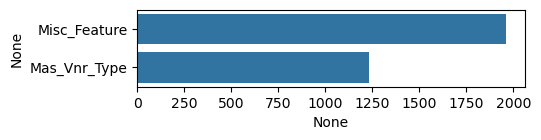

In [7]:
train_c=X_train_processed[[c for c in X_train_processed.columns if X_train_processed[c].dtypes=='object']].copy()
test_c=X_test_processed[[c for c in X_test_processed.columns if X_test_processed[c].dtypes=='object']].copy()
display(train_c.head())
display(test_c.head())
# print(train_c.shape)
fig=plt.figure(figsize=(5,1))
train_null=train_c.isnull().sum()[train_c.isnull().sum()!=0].sort_values(ascending=False)
sns.barplot(y=train_null.index,x=train_null)

In [8]:
# dropping the rows with missing values in the categorical features
X_train_processed = X_train_processed.drop(columns=train_null.index)
X_test_processed = X_test_processed.drop(columns=train_null.index)

In [9]:
def label_encoding(df: pd.DataFrame) -> pd.DataFrame:
    le = LabelEncoder()
    for col in df.select_dtypes(exclude=['number']).columns:
        df[col] = le.fit_transform(df[col])
    return df

In [10]:
X_train_processed = label_encoding(X_train_processed)
X_test_processed = label_encoding(X_test_processed)

# verify the data
display(X_train_processed.info())
display(X_train_processed.head())
display(X_test_processed.info())
display(X_test_processed.head())


<class 'pandas.core.frame.DataFrame'>
Index: 2035 entries, 526301100 to 924151050
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           2035 non-null   int64  
 1   Lot_Frontage        2035 non-null   int64  
 2   Lot_Area            2035 non-null   float64
 3   Street              2035 non-null   int64  
 4   Alley               2035 non-null   int64  
 5   Lot_Shape           2035 non-null   int64  
 6   Land_Contour        2035 non-null   int64  
 7   Utilities           2035 non-null   int64  
 8   Lot_Config          2035 non-null   int64  
 9   Land_Slope          2035 non-null   int64  
 10  Neighborhood        2035 non-null   int64  
 11  Condition_1         2035 non-null   int64  
 12  Condition_2         2035 non-null   int64  
 13  Bldg_Type           2035 non-null   int64  
 14  House_Style         2035 non-null   int64  
 15  Overall_Qual        2035 non-null   int64  
 16

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_Area,Pool_QC,Fence,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
526301100,5,141,10.366309,1,1,3,3,0,0,0,...,0.0,2,4,0.000000,5,2010,8,4,-93.619754,42.054035
526351010,5,81,9.565775,1,1,3,3,0,0,0,...,0.0,2,4,9.433564,6,2010,8,4,-93.619387,42.052659
526353030,5,93,9.320181,1,1,2,3,0,0,0,...,0.0,2,4,0.000000,4,2010,8,4,-93.617320,42.051245
527105010,5,74,9.534668,1,1,3,3,0,4,0,...,0.0,2,2,0.000000,3,2010,8,4,-93.638933,42.060899
527145080,5,43,8.518392,1,1,3,1,0,4,0,...,0.0,2,4,0.000000,1,2010,8,4,-93.633826,42.060728


<class 'pandas.core.frame.DataFrame'>
Index: 879 entries, 906380170 to 903400180
Data columns (total 78 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MS_Zoning           879 non-null    int64  
 1   Lot_Frontage        879 non-null    int64  
 2   Lot_Area            879 non-null    float64
 3   Street              879 non-null    int64  
 4   Alley               879 non-null    int64  
 5   Lot_Shape           879 non-null    int64  
 6   Land_Contour        879 non-null    int64  
 7   Utilities           879 non-null    int64  
 8   Lot_Config          879 non-null    int64  
 9   Land_Slope          879 non-null    int64  
 10  Neighborhood        879 non-null    int64  
 11  Condition_1         879 non-null    int64  
 12  Condition_2         879 non-null    int64  
 13  Bldg_Type           879 non-null    int64  
 14  House_Style         879 non-null    int64  
 15  Overall_Qual        879 non-null    int64  
 16 

None

,MS_Zoning,Lot_Frontage,Lot_Area,Street,Alley,Lot_Shape,Land_Contour,Utilities,Lot_Config,Land_Slope,...,Pool_Area,Pool_QC,Fence,Misc_Val,Mo_Sold,Year_Sold,Sale_Type,Sale_Condition,Longitude,Latitude
PID,,,,,,,,,,,,,,,,,,,,,
906380170,4,64,8.910181,1,1,2,3,0,3,0,...,0.0,3,4,0.0,7,2006,6,5,-93.690366,42.024555
902204080,5,62,8.909911,1,1,2,3,0,0,0,...,0.0,3,4,0.0,11,2009,7,4,-93.608829,42.032048
535478110,4,70,8.853808,1,1,2,3,0,3,0,...,0.0,3,4,0.0,3,2006,9,4,-93.605067,42.034561
908152270,4,60,8.857230,1,1,2,3,0,3,0,...,0.0,3,4,0.0,6,2008,9,4,-93.673251,42.018830
903458060,5,40,8.476580,1,1,2,3,0,3,0,...,0.0,3,4,0.0,7,2007,9,4,-93.625297,42.023518


#### Impute
When imputing missing values, it’s important to understand that some NaN values in the dataset represent "None" rather than truly missing or null values. These instances occur when the absence of a value has meaning, such as indicating the non-existence of a particular feature.

These Features are : 'PoolQC','BsmtQual', 'BsmtCond', 'BsmtExposure', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'Fence', 'Alley', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'GarageType', , 'MiscFeature'

In [11]:
def impute(df: pd.DataFrame) -> pd.DataFrame:
    # Vsiualize the percentages of missing values per features:
    missing_values = pd.DataFrame({'Percentage': (df.isnull().sum()/len(df)) * 100},
                                  index=df.columns)
    missing_values = missing_values[missing_values['Percentage'] > 0].sort_values(
        by='Percentage',
        ascending=False)
    missing_values.head(10)

    nan_cols = missing_values.index.tolist()
    print(nan_cols)

    for col in nan_cols:
        df[col] = df[col].fillna('None')
    return df

X_train_processed = impute(X_train_processed)
X_test_processed = impute(X_test_processed)

[]
[]


### Metric Function

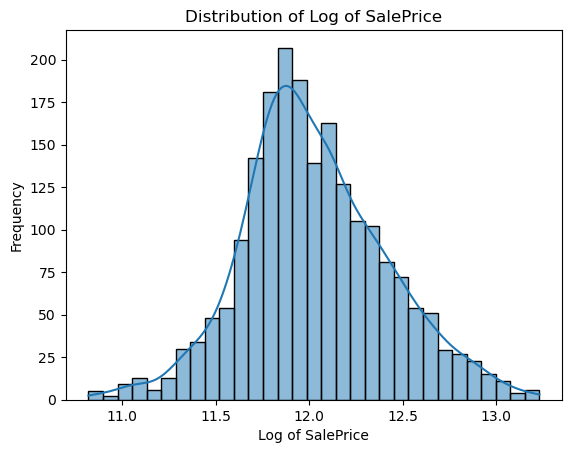

In [12]:
# Distribution of the target variable
sns.histplot(y_train_processed, kde=True) 
plt.title('Distribution of Log of SalePrice')
plt.xlabel('Log of SalePrice')
plt.ylabel('Frequency')
plt.show()

In [13]:
# def score_model(X: pd.DataFrame, y: pd.Series, model=XGBRegressor()) -> float:
#     # Metric for Housing competition is RMSE (Root Mean Squared Error)
#     score = cross_val_score(
#         model, X, y, cv=10, scoring="neg_root_mean_squared_error",
#     )
#     score = -1 * score.mean()
#     return score
# baseline_score = score_model(X_train, y_train)
# print(f"Baseline score: {baseline_score:.5f} RMSE")


def score_model(y_test: pd.Series, y_pred: pd.Series) -> float:    
    # Method2: direct calculation
    return np.sqrt(np.mean((y_pred - y_test) ** 2))

#### Feature Engineering

In [14]:
# print out all features in this step
print(X_train_processed.columns)


Index(['MS_Zoning', 'Lot_Frontage', 'Lot_Area', 'Street', 'Alley', 'Lot_Shape',
       'Land_Contour', 'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod_Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond', 'Foundation', 'Bsmt_Qual',
       'Bsmt_Cond', 'Bsmt_Exposure', 'BsmtFin_Type_1', 'BsmtFin_SF_1',
       'BsmtFin_Type_2', 'BsmtFin_SF_2', 'Bsmt_Unf_SF', 'Total_Bsmt_SF',
       'Heating', 'Heating_QC', 'Central_Air', 'Electrical', 'First_Flr_SF',
       'Second_Flr_SF', 'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',
       'Garage_Finish', 'Garage_Cars', 'Garage_Area', '

In [15]:
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df['BsmtFin_Type_1_Unf'] = 1*(df['BsmtFin_Type_1'] == 'Unf')
    df['HasWoodDeck'] = (df['Wood_Deck_SF'] == 0) * 1
    df['HasOpenPorch'] = (df['Open_Porch_SF'] == 0) * 1
    df['HasEnclosedPorch'] = (df['Enclosed_Porch'] == 0) * 1
    df['Has3SsnPorch'] = (df['Three_season_porch'] == 0) * 1
    df['HasScreenPorch'] = (df['Screen_Porch'] == 0) * 1
    df['YearsSinceRemodel'] = df['Year_Sold'].astype(int) - df['Year_Remod_Add'].astype(int)
    df['Total_Home_Quality'] = df['Overall_Qual'] + df['Overall_Cond']
    df = df.drop(['Utilities', 'Street', 'Pool_QC',], axis=1)
    df['TotalSF'] = df['Total_Bsmt_SF'] + df['First_Flr_SF'] + df['Second_Flr_SF']
    df['YrBltAndRemod'] = df['Year_Built'] + df['Year_Remod_Add']

    df['Total_sqr_footage'] = (df['BsmtFin_SF_1'] + df['BsmtFin_SF_2'] +
                                    df['First_Flr_SF'] + df['Second_Flr_SF'])
    df['Total_Bathrooms'] = (df['Full_Bath'] + (0.5 * df['Half_Bath']) +
                                df['Bsmt_Full_Bath'] + (0.5 * df['Bsmt_Half_Bath']))
    df['Total_porch_sf'] = (df['Open_Porch_SF'] + df['Three_season_porch'] +
                                df['Enclosed_Porch'] + df['Screen_Porch'] +
                                df['Wood_Deck_SF'])
    df['Total_Bsmt_SF'] = df['Total_Bsmt_SF'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    df['Second_Flr_SF'] = df['Second_Flr_SF'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)
    df['Garage_Area'] = df['Garage_Area'].apply(lambda x: np.exp(6) if x <= 0.0 else x)
    df['Garage_Cars'] = df['Garage_Cars'].apply(lambda x: 0 if x <= 0.0 else x)
    df['Lot_Frontage'] = df['Lot_Frontage'].apply(lambda x: np.exp(4.2) if x <= 0.0 else x)
    df['Mas_Vnr_Area'] = df['Mas_Vnr_Area'].apply(lambda x: np.exp(4) if x <= 0.0 else x)
    df['BsmtFin_SF_1'] = df['BsmtFin_SF_1'].apply(lambda x: np.exp(6.5) if x <= 0.0 else x)

    df['haspool'] = df['Pool_Area'].apply(lambda x: 1 if x > 0 else 0)
    df['has2ndfloor'] = df['Second_Flr_SF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasgarage'] = df['Garage_Area'].apply(lambda x: 1 if x > 0 else 0)
    df['hasbsmt'] = df['Total_Bsmt_SF'].apply(lambda x: 1 if x > 0 else 0)
    df['hasfireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
    
    return df

In [16]:
X_train_processed = feature_engineering(X_train_processed)
X_test_processed = feature_engineering(X_test_processed)

### Select the optimal span

In [17]:
# branch out the full training data into full and optimal span
X_train_opt = X_train_processed.copy()
y_train_opt = y_train_processed.copy()

X_test_opt = X_test_processed.copy()
y_test_opt = y_test_processed.copy()

#### Mutual Information
Mutual Information (MI) and correlation both measure relationships between variables, but MI captures both linear and non-linear dependencies, while correlation only detects linear relationships.

Correlation is simple to interpret, ranging from -1 to 1, and works well for continuous numerical data with linear dependencies. MI, on the other hand, can handle both categorical and continuous data, detecting more complex relationships but is less intuitive and computationally more expensive.

In [18]:
from sklearn.feature_selection import mutual_info_regression

# Function to calculate mi_scores:
def make_mi_scores(X, y):
    X = X.copy()
    # Encode categorical features:
    # All discrete features should now have integer dtypes
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # extract discrete features:
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, 
                                      discrete_features=discrete_features,
                                      random_state=0)
    # Store mi scores in a serie
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    # Sort the mi scores
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [19]:
scores_mi = make_mi_scores(X_train_opt, y_train_opt)
print(scores_mi)

TotalSF              0.705761
Overall_Qual         0.591884
Neighborhood         0.558077
Total_sqr_footage    0.541898
Gr_Liv_Area          0.479491
                       ...   
Mo_Sold              0.000000
Condition_2          0.000000
Pool_Area            0.000000
Land_Slope           0.000000
haspool              0.000000
Name: MI Scores, Length: 93, dtype: float64


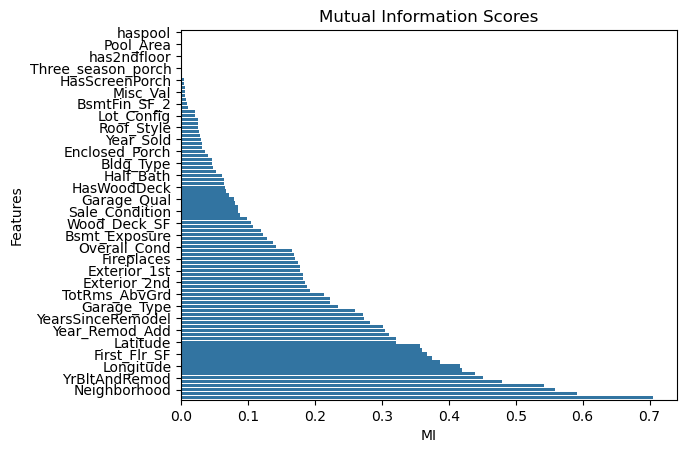

In [20]:
# Function to plot the mi_scores:
def plot_mi_scores(scores):
    # sort the scores:
    scores = scores.sort_values(ascending=True)
    sns.barplot(x=scores, y=scores.index)
    plt.xlabel('MI')
    plt.ylabel('Features')
    plt.title('Mutual Information Scores')
    # Set y-axis tick locations and labels
    tick_locations = range(0, len(scores.index), 3)  # every 2 units
    tick_labels = scores.index[tick_locations]
    plt.yticks(tick_locations, tick_labels)
plot_mi_scores(scores_mi)

In [21]:
# Function to drop uninformative features:
def drop_uninformative(df, mi_scores):
    # drop the features with MI scores less than 0.0
    print(f"Dropping features with MI scores less than 0.0: {mi_scores[mi_scores == 0.0].index.tolist()}")
    return df.loc[:, mi_scores > 0.01]

X_train_opt = drop_uninformative(X_train_opt, scores_mi)
X_test_opt = drop_uninformative(X_test_opt, scores_mi)

Dropping features with MI scores less than 0.0: ['Mo_Sold', 'Condition_2', 'Pool_Area', 'Land_Slope', 'haspool']
Dropping features with MI scores less than 0.0: ['Mo_Sold', 'Condition_2', 'Pool_Area', 'Land_Slope', 'haspool']


#### Correlation
Correlation between numerical features and a target variable is a statistical measure that indicates the strength and direction of a linear relationship between them. In predictive modeling, understanding this correlation is crucial, as it helps identify which features significantly impact the target variable. A strong positive correlation suggests that as one feature increases, the target variable tends to increase as well, while a strong negative correlation indicates that an increase in the feature corresponds to a decrease in the target variable.

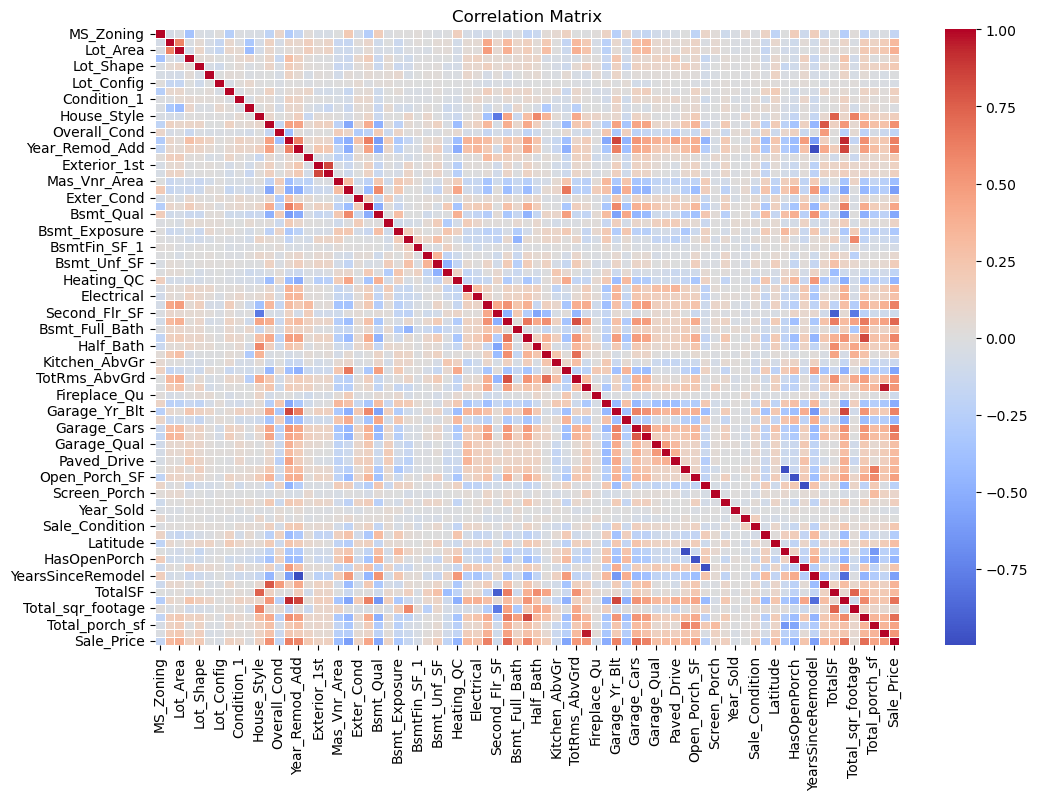

In [22]:
# correlation between the features and the target
# concatenate the features and the target
X_train_corr = pd.concat([X_train_opt, y_train_opt], axis=1)
corr_matrix = X_train_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


In [23]:
# # drop the features with low correlation with the target
# corr_threshold = 0.05
# drop_cols = X_train_corr.columns[X_train_corr.corr()['Sale_Price'] < corr_threshold]
# print("Dropped columns:", drop_cols)
# X_train_opt = X_train_opt.drop(columns=drop_cols)
# X_test_opt = X_test_opt.drop(columns=drop_cols)


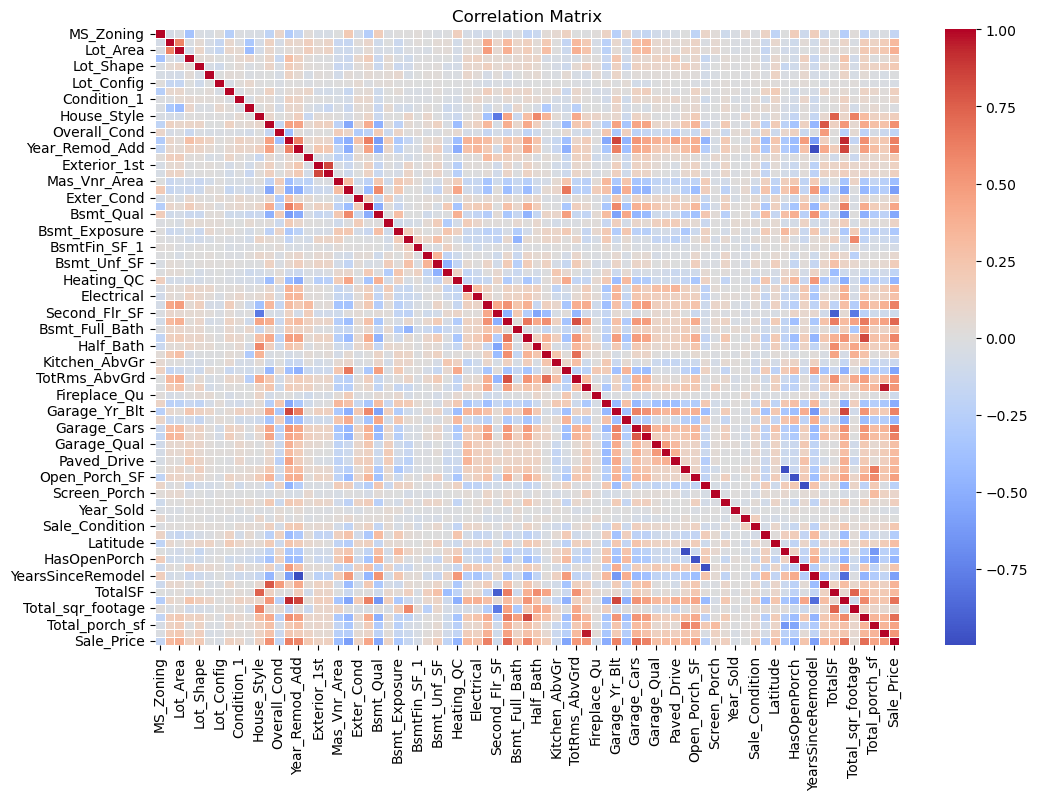

In [24]:
# recompute the correlation matrix
X_train_opt_corr = pd.concat([X_train_opt, y_train_opt], axis=1)
corr_matrix_opt = X_train_opt_corr.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_opt, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

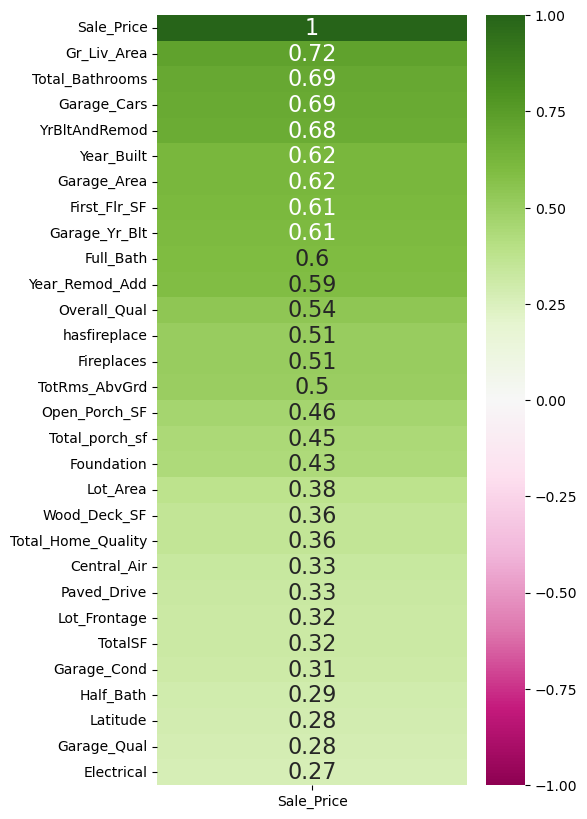

In [25]:
plt.figure(figsize=(5,10))
sns.heatmap(corr_matrix_opt[['Sale_Price']].sort_values(by=['Sale_Price'],ascending=False).head(30),annot_kws={"size": 16},vmin=-1, cmap='PiYG', annot=True)
plt.show()

**Co-linearity**

We will choose only one feature from each co-linear pair.

In [26]:
# find out all hightly correlated features (colinear pairs)
highly_correlated_threshold = 0.8
highly_correlated_matrix = corr_matrix_opt[corr_matrix_opt > highly_correlated_threshold]
highly_correlated_matrix = highly_correlated_matrix[highly_correlated_matrix < 1]

# print the correlated pairs (not nan)
correlated_pairs = set()

target = 'Sale_Price'
for p1 in highly_correlated_matrix.columns:
    # check if the correlation contains nan
    if pd.notna(highly_correlated_matrix[p1]).any():
        # print the correlated features
        p2_list = highly_correlated_matrix[p1].dropna().index.tolist()
        for p2 in p2_list:
            # Create a sorted tuple of the pair to ensure uniqueness
            pair = tuple(sorted([p1, p2]))
            if pair not in correlated_pairs:
                print(f"{pair[0]} and {pair[1]}")
                print(f"  {p1} and {p2} correlation: {highly_correlated_matrix[p1][p2]:.3f}")
                print(f"  {target} and {p1} correlation: {corr_matrix_opt[target][p1]:.3f}")
                print(f"  {target} and {p2} correlation: {corr_matrix_opt[target][p2]:.3f}")
                correlated_pairs.add(pair)

print(f"Number of correlated pairs: {len(correlated_pairs)}")

Garage_Yr_Blt and Year_Built
  Year_Built and Garage_Yr_Blt correlation: 0.848
  Sale_Price and Year_Built correlation: 0.619
  Sale_Price and Garage_Yr_Blt correlation: 0.609
Year_Built and YrBltAndRemod
  Year_Built and YrBltAndRemod correlation: 0.931
  Sale_Price and Year_Built correlation: 0.619
  Sale_Price and YrBltAndRemod correlation: 0.675
Year_Remod_Add and YrBltAndRemod
  Year_Remod_Add and YrBltAndRemod correlation: 0.849
  Sale_Price and Year_Remod_Add correlation: 0.588
  Sale_Price and YrBltAndRemod correlation: 0.675
Exterior_1st and Exterior_2nd
  Exterior_1st and Exterior_2nd correlation: 0.839
  Sale_Price and Exterior_1st correlation: 0.141
  Sale_Price and Exterior_2nd correlation: 0.150
Gr_Liv_Area and TotRms_AbvGrd
  Gr_Liv_Area and TotRms_AbvGrd correlation: 0.810
  Sale_Price and Gr_Liv_Area correlation: 0.720
  Sale_Price and TotRms_AbvGrd correlation: 0.502
Full_Bath and Total_Bathrooms
  Full_Bath and Total_Bathrooms correlation: 0.830
  Sale_Price and Full

0 ('Gr_Liv_Area', 'TotRms_AbvGrd')
1 ('Exterior_1st', 'Exterior_2nd')
2 ('Year_Remod_Add', 'YrBltAndRemod')
3 ('Garage_Yr_Blt', 'YrBltAndRemod')
4 ('Fireplaces', 'hasfireplace')
5 ('Garage_Yr_Blt', 'Year_Built')
6 ('Full_Bath', 'Total_Bathrooms')
7 ('Year_Built', 'YrBltAndRemod')


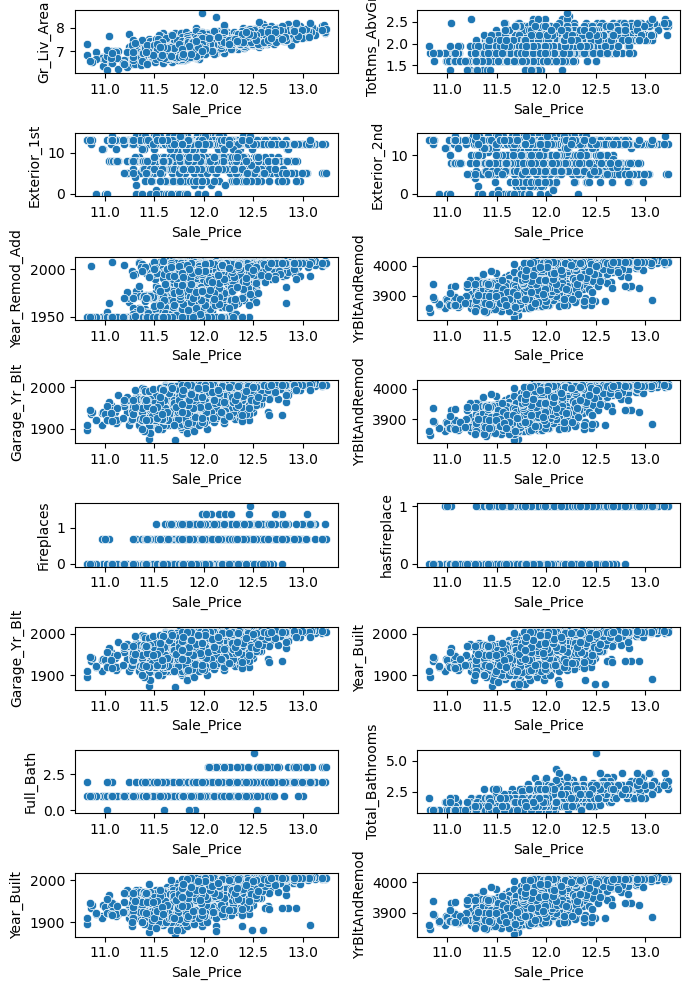

In [27]:
fig, ax = plt.subplots(len(correlated_pairs), 2, figsize=(7, 10))
for i, pair in enumerate(correlated_pairs):
    print(i, pair)
    sns.scatterplot(x = 'Sale_Price', y = pair[0], data=X_train_corr, ax=ax[i][0])
    sns.scatterplot(x = 'Sale_Price', y = pair[1], data=X_train_corr, ax=ax[i][1])

fig.tight_layout()

In [28]:
# According to the scatter plots, we will drop the features with lower correlation with the target
drop_cols = ['Garage_Yr_Blt', 'Garage_Cars', 'TotRms_AbvGrd', 'House_Style']
X_train_opt = X_train_opt.drop(columns=drop_cols)
X_test_opt = X_test_opt.drop(columns=drop_cols)

#### Remove non-linear features
We have removed co-linearity from our dataset, Now we will manually examine each feature and remove non-linear features from the dataset

In [29]:
# print(X_train_opt.columns, len(X_train_opt.columns))
# fig, ax = plt.subplots((len(X_train_opt.columns) + 1) // 2, 2, figsize=(15, 60))

# def graph(X_full: pd.DataFrame, xlabel: str, r: float, c: float):
#     sns.scatterplot(x=xlabel, y='Sale_Price', data=X_full, color=('orange'), ax=ax[r][c])
#     ax[r][c].set_xlabel(xlabel)
#     fig.tight_layout(pad=5.0)

# for r, col in enumerate(X_train_opt.columns):
#     c = r % 2
#     graph(X_train_full, col, r//2, c)

In [30]:
# non_linear_cols = ["Alley","Lot_Shape","Neighborhood","Overall_Qual","Roof_Style","Exterior_1st","Exterior_2nd","Exter_Cond","Foundation","Bsmt_Cond","Central_Air","Electrical","Bsmt_Full_Bath","Full_Bath","Half_Bath","Bedroom_AbvGr","Fireplaces","Garage_Qual","Garage_Cond","Paved_Drive","Screen_Porch","Fence","Sale_Condition"]
# # X_train_opt = X_train_opt.drop(columns=non_linear_cols)
# # X_test_opt = X_test_opt.drop(columns=non_linear_cols)

# # the remaining features
# print(X_train_opt.columns, len(X_train_opt.columns))

#### Outliers Detection
Outliers are data points that significantly differ from other observations in a dataset. In the context of house price prediction, these outliers can represent properties with extreme values in terms of price, size, or other features (like luxury mansions or unusually small houses). These can distort the patterns in the data, affecting the performance of machine learning models.

For house price prediction, outliers can skew the model's understanding of the relationship between features and price, potentially leading to poor generalization on unseen data. To address this, techniques such as removing or transforming outliers (using logarithmic scaling or robust statistical methods) are commonly employed. However, the approach to outliers must be carefully chosen so as not to discard valuable information or alter the true nature of the data.

#### Scatter Plots
The scatter plots created by this code can help identify outliers in the data. Here are some ways to detect outliers from these plots:

- Visual Inspection: By visually inspecting the scatter plots, you can identify points that are far away from the main cluster of points. These points may be outliers.
- Points far from the regression line: If you were to draw a regression line on each scatter plot, points that are far away from the line may be considered outliers.
- Points with unusual x or y values: If a point has an x or y value that is significantly different from the rest of the data, it may be an outlier

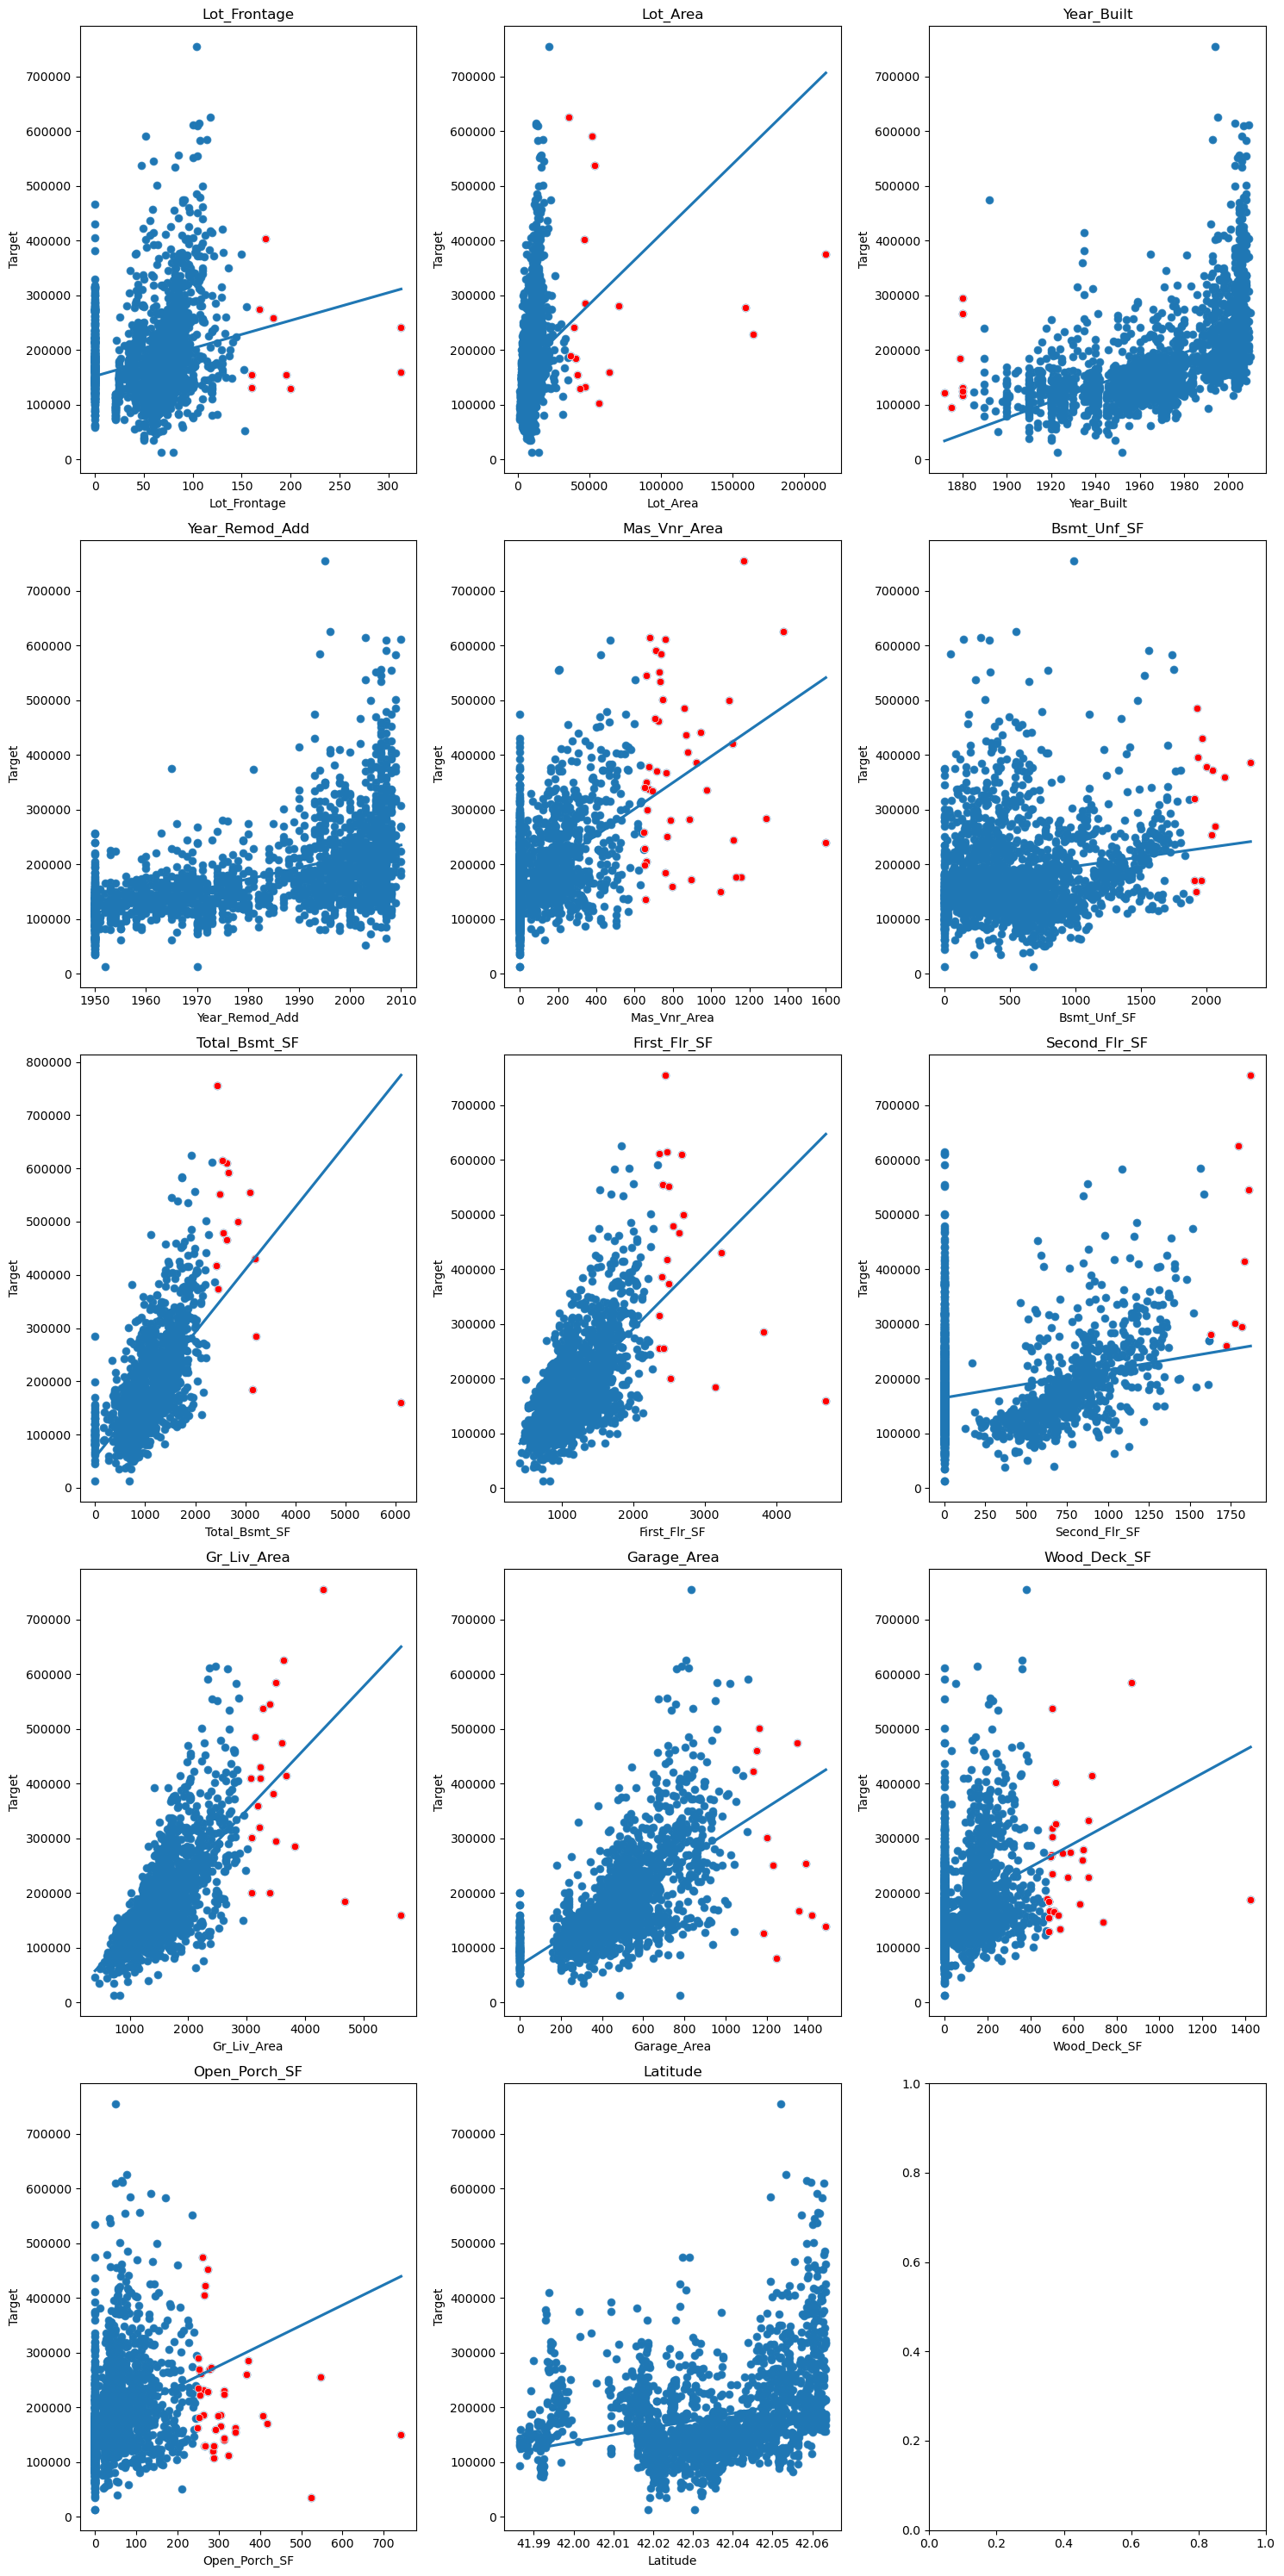

In [31]:
from scipy import stats

# Define the 6 features
# features = ['Gr_Liv_Area', 'Total_Bsmt_SF', 'First_Flr_SF',
            # 'Bsmt_Unf_SF', 'Lot_Area', 'Garage_Area']
linear_num_features = ['Lot_Frontage', 'Lot_Area', 'Year_Built', 'Year_Remod_Add',
       'Mas_Vnr_Area', 'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'First_Flr_SF',
       'Second_Flr_SF', 'Gr_Liv_Area', 'Garage_Area', 'Wood_Deck_SF',
       'Open_Porch_SF', 'Latitude']

# Create a figure and axis object
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 30))

z_score_threshold = 3

# Loop through each feature
for i, feature in enumerate(linear_num_features):
    row = i // 3
    col = i % 3
    ax = axs[row, col]

    # Create a scatter plot
    sns.scatterplot(x=feature, y='Sale_Price', data=X_train_full, ax=ax)

    # Fit a linear line
    sns.regplot(x=feature, y='Sale_Price', data=X_train_full, ax=ax, ci=None)

    # Identify outliers using Z-score method
    z_scores = np.abs(stats.zscore(X_train_full[feature]))
    outliers = X_train_full[z_scores > z_score_threshold]

    # Color outliers
    sns.scatterplot(x=feature, y='Sale_Price',
                    data=outliers, ax=ax, color='red')

    # Set title and labels
    ax.set_title(feature)
    ax.set_xlabel(feature)
    ax.set_ylabel('Target')

# Show the plot
plt.tight_layout()
plt.show()

In [32]:
def delete_outliers(X: pd.DataFrame, y: pd.Series, feature: str, threshold: float) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(X[feature]))
    outliers = X[z_scores > threshold]
    print(f"Dropping {len(outliers)} outliers in {feature}")
    return X.drop(outliers.index), y.drop(outliers.index)


# outliers_features = ["Lot_Frontage", "Lot_Area", "Mas_Vnr_Area", "Total_Bsmt_SF",
#                      "First_Flr_SF", "Gr_Liv_Area", "Garage_Area", "Wood_Deck_SF", "Open_Porch_SF"]
for feature in linear_num_features:
    X_train_opt, y_train_opt = delete_outliers(X_train_opt, y_train_opt, feature, z_score_threshold)
    X_test_opt, y_test_opt = delete_outliers(X_test_opt, y_test_opt, feature, z_score_threshold)


Dropping 19 outliers in Lot_Frontage
Dropping 11 outliers in Lot_Frontage
Dropping 47 outliers in Lot_Area
Dropping 20 outliers in Lot_Area
Dropping 3 outliers in Year_Built
Dropping 0 outliers in Year_Built
Dropping 0 outliers in Year_Remod_Add
Dropping 0 outliers in Year_Remod_Add
Dropping 0 outliers in Mas_Vnr_Area
Dropping 0 outliers in Mas_Vnr_Area
Dropping 164 outliers in Bsmt_Unf_SF
Dropping 0 outliers in Bsmt_Unf_SF
Dropping 17 outliers in Total_Bsmt_SF
Dropping 25 outliers in Total_Bsmt_SF
Dropping 2 outliers in First_Flr_SF
Dropping 2 outliers in First_Flr_SF
Dropping 0 outliers in Second_Flr_SF
Dropping 0 outliers in Second_Flr_SF
Dropping 3 outliers in Gr_Liv_Area
Dropping 3 outliers in Gr_Liv_Area
Dropping 13 outliers in Garage_Area
Dropping 8 outliers in Garage_Area
Dropping 0 outliers in Wood_Deck_SF
Dropping 0 outliers in Wood_Deck_SF
Dropping 0 outliers in Open_Porch_SF
Dropping 0 outliers in Open_Porch_SF
Dropping 0 outliers in Latitude
Dropping 0 outliers in Latitude

### Linear regression models
#### Full Model

In [33]:
# full model with no penalty
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Full model score: {score_model(y_test_opt, y_pred):.5f} RMSE")


Full model score: 0.13833 RMSE


#### Lasso Regression

Lasso alpha: 0.00003
Lasso score: 0.13815 RMSE
alpha_min 2.656087782946684e-05
alpha_1se 9.770099572992247e-05
Lasso score with optimal alpha: 0.13766 RMSE


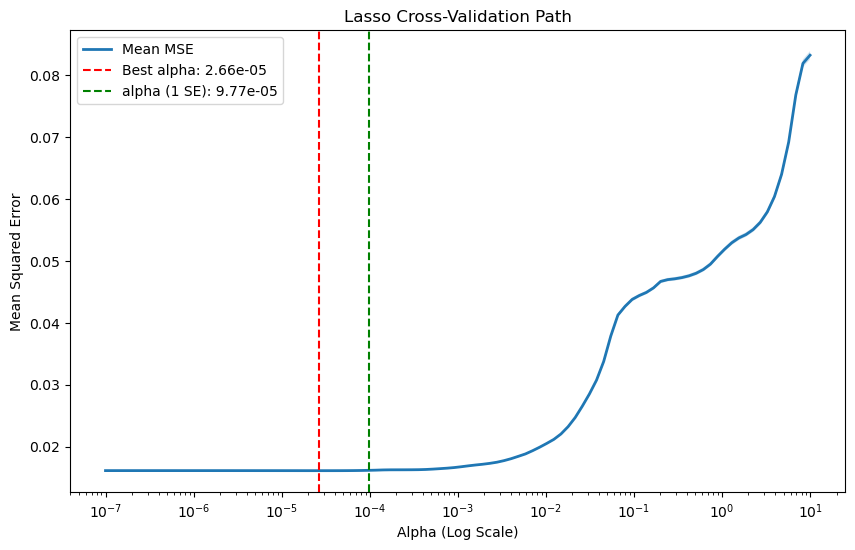

In [34]:
# Lasso Regression
from sklearn.linear_model import LassoCV, Lasso
lasso_alphas = np.logspace(-7, 1, 100)
lassoCV = LassoCV(alphas=lasso_alphas, cv=5, random_state=seed_val)
lassoCV.fit(X_train_opt, y_train_opt)
lasso_cv_alpha = lassoCV.alpha_
print(f"Lasso alpha: {lasso_cv_alpha:.5f}")

# verify the model with the test data
y_pred_lasso = lassoCV.predict(X_test_opt)
print(f"Lasso score: {score_model(y_test_opt, y_pred_lasso):.5f} RMSE")

n = len(X_train_opt.columns)
mean_mse = np.mean(lassoCV.mse_path_, axis=1)
std_mse = np.std(lassoCV.mse_path_, axis=1) / np.sqrt(n) 

cv_alphas = lassoCV.alphas_
min_idx = np.argmin(mean_mse)

alpha_min = cv_alphas[min_idx]

threshold = mean_mse[min_idx] + std_mse[min_idx]
alpha_1se = max(cv_alphas[np.where(mean_mse <= threshold)])

print("alpha_min", alpha_min)
print("alpha_1se", alpha_1se)

mean_mse = np.array(mean_mse)
std_mse = np.array(std_mse)

# Lasso with the optimal alpha
lasso_model_min = Lasso(alpha = alpha_1se, max_iter=10000)
lasso_model_min.fit(X_train_opt, y_train_opt)
y_pred_lasso_min = lasso_model_min.predict(X_test_opt)
print(f"Lasso score with optimal alpha: {score_model(y_test_opt, y_pred_lasso_min):.5f} RMSE")

plt.figure(figsize=(10, 6))
plt.semilogx(cv_alphas, mean_mse, label='Mean MSE', linewidth=2)
plt.fill_between(cv_alphas, mean_mse - std_mse, mean_mse + std_mse, alpha=0.2)
plt.axvline(alpha_min, linestyle='--', color='r', label=f'Best alpha: {alpha_min:.2e}')
plt.axvline(alpha_1se, linestyle='--', color='g', label=f'alpha (1 SE): {alpha_1se:.2e}')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Lasso Cross-Validation Path')
plt.show()

#### Ridge Regression


In [35]:
# ridge regression CV path plot
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler


In [36]:
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4,
                1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=10))
ridge.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred_ridge = ridge.predict(X_test_opt)
print(f"Ridge score: {score_model(y_test_opt, y_pred_ridge):.5f} RMSE")

Ridge score: 0.13832 RMSE


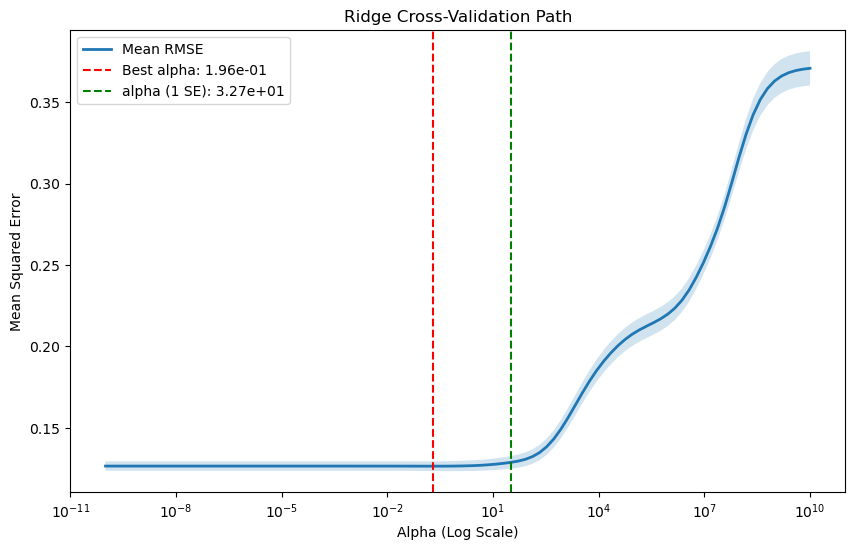

In [37]:
mean_rmse = []
std_rmse = []
ridge_alphas = np.logspace(-10, 10, 100)

for alpha in ridge_alphas:
    ridge = Ridge(alpha=alpha)
    rmse = -cross_val_score(ridge, X_train_opt, y_train_opt, cv=10, scoring='neg_root_mean_squared_error')
    mean_rmse.append(np.mean(rmse))
    std_rmse.append(np.std(rmse) / np.sqrt(10))

# Identify best alpha and one standard error rule alpha
min_idx = np.argmin(mean_rmse)
alpha_min = ridge_alphas[min_idx]

# Find the threshold within one standard error of the best alpha
threshold = mean_rmse[min_idx] + std_rmse[min_idx]

# Find the largest alpha within one standard error of the best alpha
one_se_rule_idx = np.where(mean_rmse <= threshold)[0][-1]
alpha_1se = ridge_alphas[one_se_rule_idx]

alpha_min, alpha_1se

mean_rmse = np.array(mean_rmse)
std_rmse = np.array(std_rmse)

plt.figure(figsize=(10, 6))
plt.semilogx(ridge_alphas, mean_rmse, label='Mean RMSE', linewidth=2)
plt.fill_between(ridge_alphas, mean_rmse - std_rmse, mean_rmse + std_rmse, alpha=0.2)
plt.axvline(alpha_min, linestyle='--', color='r', label=f'Best alpha: {alpha_min:.2e}')
plt.axvline(alpha_1se, linestyle='--', color='g', label=f'alpha (1 SE): {alpha_1se:.2e}')
plt.xlabel('Alpha (Log Scale)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Ridge Cross-Validation Path')
plt.show()

In [38]:
# retrain the ridge model with the optimal alpha
ridge_model_min = make_pipeline(RobustScaler(), Ridge(alpha = alpha_min))
ridge_model_min.fit(X_train_opt, y_train_opt)
y_pred_ridge_min = ridge_model_min.predict(X_test_opt)
print(f"Ridge score with optimal alpha: {score_model(y_test_opt, y_pred_ridge_min):.5f} RMSE")


Ridge score with optimal alpha: 0.13832 RMSE


#### Elasticnet Regression

In [39]:
from sklearn.linear_model import ElasticNetCV
model = ElasticNetCV(alphas=np.logspace(-7, 1, 100), cv=10, random_state=seed_val)
model.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred = model.predict(X_test_opt)
print(f"Elasticnet score: {score_model(y_test_opt, y_pred):.5f} RMSE")


Elasticnet score: 0.13814 RMSE


### Tree models
randomForest or boosting tree

In [40]:
# # Random Forest
# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_estimators=1200,
#                           max_depth=15,
#                           min_samples_split=5,
#                           min_samples_leaf=5,
#                           max_features=None,
#                           oob_score=True,
#                           random_state=seed_val)
# rf.fit(X_train_opt, y_train_opt)

# # verify the model with the test data
# y_pred_rf = rf.predict(X_test_opt)
# print(f"Random Forest score: {score_model(y_test_opt, y_pred_rf):.5f} RMSE")

In [41]:
# Boosting Tree
from xgboost import XGBRegressor
xgboost = XGBRegressor(objective='reg:squarederror', n_estimators=6000, max_depth=4, learning_rate=0.01, random_state=seed_val)
xgboost.fit(X_train_opt, y_train_opt)

# verify the model with the test data
y_pred_xgboost = xgboost.predict(X_test_opt)
print(f"Boosting Tree score: {score_model(y_test_opt, y_pred_xgboost):.5f} RMSE")

Boosting Tree score: 0.11935 RMSE


In [42]:
xgb_params = {'max_depth': 6,
              'learning_rate': 0.0054327375927544245,
              'n_estimators': 3860,
              'min_child_weight': 3,
              'colsample_bytree': 0.2460611837296628,
              'subsample': 0.27927638624844453,
              'reg_alpha': 0.028227088223601027,
              'reg_lambda': 0.015803764385717418,
              'random_state': seed_val}

xgb_tuned = XGBRegressor(**xgb_params)
xgb_tuned.fit(X_train_opt, y_train_opt)
y_pred_xgb_tuned = xgb_tuned.predict(X_test_opt)
score = score_model(y_test_opt, y_pred_xgb_tuned)
print(f"Score: {score:.5f} RMSLE")

Score: 0.11646 RMSLE
